# Long short-term memory
___

This model is based on:

```Bibtex
@inproceedings{daxenbergerWhatEssenceClaim2017,
  title = {What Is the Essence of a Claim? {{Cross-domain}} Claim Identification},
  author = {Daxenberger, Johannes and Eger, Steffen and Habernal, Ivan and Stab, Christian and Gurevych, Iryna},
  date = {2017},
  doi = {10.18653/v1/d17-1218},
}
```

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from src.dataset import load_dataset
from config import PROJECT_NAME, DATASET_2014_PATH, DATASET_2014_NAME, DATASET_2018_PATH, DATASET_2018_NAME

import wandb
from wandb.keras import WandbCallback

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-01-18 15:12:03.908946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:12:03.914558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:12:03.914944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
MODEL_NAME = "LSTM"
TRACKING = False
FALSE_CLASS_BALANCE = 1.0
# DATASET_2014_PATH = os.path.join(base_dir, "CE-ACL_processed.csv")
# DATASET_2018_PATH = os.path.join(base_dir, "claim_sentence_search.csv")
# DATASET_2014_NAME = "IBM_Debater_(R)_CE-ACL-2014.v0"
# DATASET_2018_NAME = "IBM_Debater_(R)_claim_sentences_search"
# PROJECT_NAME = "Claim detection models"

### 0. Load data

In [4]:
X_train, X_test, y_train, y_test = load_dataset(dataset_path=DATASET_2014_PATH, false_class_balance=FALSE_CLASS_BALANCE)

In [5]:
y_train = y_train.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

### 1. Create embeddings

In [6]:
max_words = 5000  # consider the top n words in the data set only
maxlen = len(X_train["Sentence"].max())  # longest sentence to calculate max embedding len

tokenizer = Tokenizer(num_words=max_words)  # create tokanizer
tokenizer.fit_on_texts(X_train["Sentence"])  # tokenize sentences

def create_embeddings(data, labels):
  sequences = tokenizer.texts_to_sequences(data["Sentence"]) # get sequences for sentences

  data = pad_sequences(sequences, maxlen=maxlen) # padding for shorter sentences
  labels = np.asarray(labels) # return labels

  # reporting
  word_index = tokenizer.word_index
  print('Found %s unique tokens' % len(word_index))
  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)

  return data, labels

### 2. Prepare dataset

In [7]:
X_train, y_train = create_embeddings(X_train, y_train)
X_test, y_test = create_embeddings(X_test, y_test)

Found 8330 unique tokens
Shape of data tensor: (1974, 197)
Shape of label tensor: (1974,)
Found 8330 unique tokens
Shape of data tensor: (494, 197)
Shape of label tensor: (494,)


### 3. Create Model

In [8]:
# Set hyperparameter
epochs = 4
batch_size = 128

In [9]:
embedding_vecor_length = 60
model = Sequential()

model.add(Embedding(max_words, embedding_vecor_length, input_length=maxlen))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 197, 60)           300000    
                                                                 
 lstm (LSTM)                 (None, 100)               64400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 364,501
Trainable params: 364,501
Non-trainable params: 0
_________________________________________________________________
None


2022-01-18 15:12:12.903953: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 15:12:12.904472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:12:12.905055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 15:12:12.905554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": DATASET_2014_NAME,
              "train_data_size": len(X_train)*0.8,
              "validation_data_size": len(X_train)*0.2,
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": None,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

### 4. Train model

In [11]:
if TRACKING:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,  callbacks=[WandbCallback()])
else:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/4


2022-01-18 15:12:17.497868: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13/13 [==============================] - 6s 349ms/step - loss: 0.6882 - accuracy: 0.5307 - val_loss: 0.6683 - val_accuracy: 0.5570
Epoch 2/4
13/13 [==============================] - 4s 335ms/step - loss: 0.6517 - accuracy: 0.6460 - val_loss: 0.6493 - val_accuracy: 0.6278
Epoch 3/4
13/13 [==============================] - 4s 335ms/step - loss: 0.5805 - accuracy: 0.7087 - val_loss: 0.5909 - val_accuracy: 0.6759
Epoch 4/4
13/13 [==============================] - 4s 335ms/step - loss: 0.4378 - accuracy: 0.8214 - val_loss: 0.5440 - val_accuracy: 0.7089


### 5. Predict results

In [12]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

16/16 [==============================] - 1s 40ms/step - loss: 0.5172 - accuracy: 0.7328
Accuracy: 73.28%


In [13]:
predictions = model.predict(np.array(X_test))

In [14]:
y_pred = []
for i in predictions:
  if i < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

### 6. Evaluate results

In [14]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.88      0.75       235
           1       0.84      0.59      0.70       259

    accuracy                           0.73       494
   macro avg       0.75      0.74      0.73       494
weighted avg       0.76      0.73      0.72       494



In [15]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [16]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

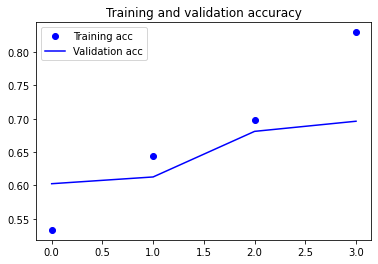

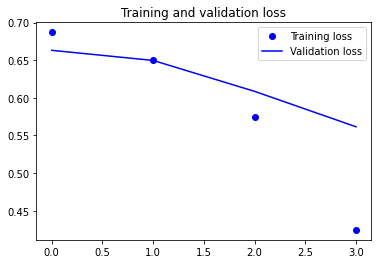

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()